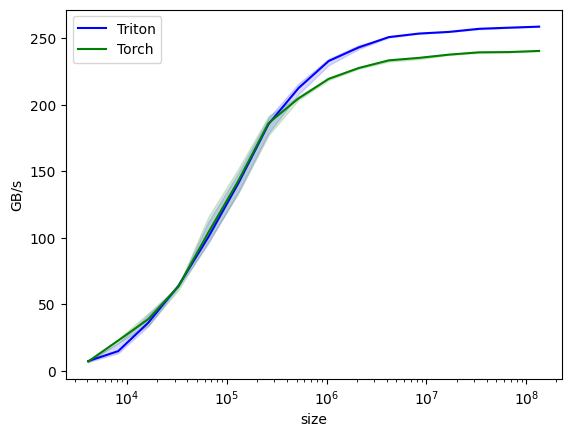

vector-add-performance:
           size      Triton       Torch
0        4096.0    7.492683    7.177570
1        8192.0   14.985366   22.925373
2       16384.0   36.355028   39.009524
3       32768.0   63.999998   63.503877
4       65536.0  100.721310  104.135590
5      131072.0  141.241379  143.091705
6      262144.0  185.479239  186.181817
7      524288.0  212.549189  204.800005
8     1048576.0  232.809939  219.428568
9     2097152.0  243.025961  227.555555
10    4194304.0  250.775518  233.293381
11    8388608.0  253.422062  235.159459
12   16777216.0  254.673575  237.601728
13   33554432.0  257.003920  239.337157
14   67108864.0  257.846562  239.526229
15  134217728.0  258.626946  240.386520


In [6]:
import torch
import triton
import triton.language as tl
import torch
from torch import Tensor
import math
DEVICE = triton.runtime.driver.active.get_active_torch_device()

@triton.jit
def vector_add_kernel(
        u_pointer, # pointer to the start element of u
        v_pointer, # pointer to the start element of u
        out_pointer, # pointer to the start element of u
        n_elements,
        block_size:tl.constexpr
    ):
    #the program id, gives the chunk index
    pid = tl.program_id(axis=0)

    # get the start/end pointers of the chunk
    pointer_start = pid * block_size
    chunk_pointer = pointer_start + tl.arange(0, block_size) #list of pointers
    mask = chunk_pointer < n_elements

    # Load the vector chunks in the GPU memory
    u = tl.load(u_pointer + chunk_pointer, mask)
    v = tl.load(v_pointer + chunk_pointer, mask)

    # compute the result
    chunk_result = u + v

    #store the result back in the DRAM
    tl.store(out_pointer + chunk_pointer, chunk_result, mask)

def triton_add(u: Tensor, v: Tensor) -> Tensor:
    assert v.device == u.device, 'u,v must be on the same device'

    n_elements = v.shape[0]

    # preallocate output
    out = torch.empty_like(u)

    # Use 1D grid to perform computations. Split the vectors in chunks,
    # each program (point of the grid) will process only 1 chunk
    # Approach 1: specify block_size upfront and compute the grid by hand
    block_size = 128
    grid = (math.ceil(n_elements / block_size)),

    vector_add_kernel[grid](u, v, out, n_elements, block_size)

    # approach 2: pass block_size as argument of the kernel, and define
    # grid as a lamda function of the meta paraters passed to the kernel
    # (this way grid is computed depending on block_size passed to the
    # kernek)
    # grid = lambda meta: (triton.cdiv(n_elements, meta['block_size']), )
    # add_kernel[grid](u, v, out, n_elements, block_size)

    return out


def python_add(u: Tensor, v: Tensor) -> Tensor:
    return u + v



@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))


def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: python_add(x, y), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(print_data=True, show_plots=True)




# New Section

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
